# File and libraries

In [6]:
import pandas as pd
import numpy as np


filepath=r'data/df_merch_7_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

file_tag = "df_merch_final"

# DSLabs functions

In [7]:
%run "scripts/dslabs_functions.py"


# Data functions

In [8]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [9]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False

if test_data==True:

    data=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample
    data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)

    # data=data.sample(frac=0.05, replace=False)
    # test=test.sample(frac=0.05, replace=False)
    # train=train.sample(frac=0.05, replace=False)
    
    
else:
    data=pd.read_csv(f"{filepath}.csv")  
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # larger sample 10%
    # data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)
    # test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)
    # train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)

 
target='returning_user'
target_metric='f2'
vars: list[str] = data.columns.to_list()
labels: list = list(data[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)
test.sort_values(by='day_of_year', inplace=True)
train.sort_values(by='day_of_year', inplace=True)



data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363410 entries, 0 to 363409
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   device_category           363410 non-null  float64
 1   traffic_source_medium     363410 non-null  float64
 2   traffic_source_source     363410 non-null  float64
 3   day_of_year               363410 non-null  float64
 4   page_path_level_3         363410 non-null  float64
 5   path_length               363410 non-null  float64
 6   time_of_day_sin           363410 non-null  float64
 7   time_of_day_cos           363410 non-null  float64
 8   local_hour_sin            363410 non-null  float64
 9   local_hour_cos            363410 non-null  float64
 10  local_minute_sin          363410 non-null  float64
 11  local_minute_cos          363410 non-null  float64
 12  hour_minute_fraction_sin  363410 non-null  float64
 13  hour_minute_fraction_cos  363410 non-null  float6

# Distribution Check

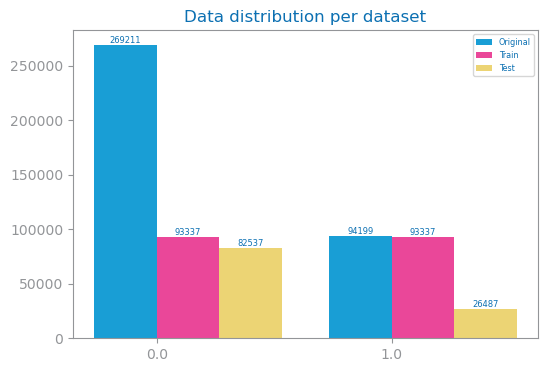

In [10]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Original": [
        len(data[data[target] == 0]),  # Assuming 0 is the negative class
        len(data[data[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

# Model Evaluation

In [12]:
if evaluate==True:
    
    trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
    print(f'Train#={len(trnX)} Test#={len(tstX)}')
    print(f'Labels={labels}')

Train#=186674 Test#=109024
Labels=[0.0, 1.0]


## recall evaluation

In [ ]:
if evaluate==True:

    best_model_recall, recall_params = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric='recall')
    savefig(f'images/{file_tag}_knn_recall_study.png')
    show()

## evaluate precision

In [ ]:
if evaluate==True:

    best_model_prec, prec_params = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric='precision')
    savefig(f'images/{file_tag}_knn_precision_study.png')
    show()

## evaluate f2

In [ ]:
if evaluate==True:

    best_model_fl, fl_params = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric='f2')
    savefig(f'images/{file_tag}_knn_accuracy_study.png')
    show()

## Evaluate for best model

In [ ]:
if evaluate==True:

    figure()


    best_model, params = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric=target_metric)
    savefig(f'images/{file_tag}_knn_{target_metric}_study.png')
    show()

# Best Model Performance

In [ ]:
if evaluate == True:
    prd_trn: array = best_model.predict(trnX)
    prd_tst: array = best_model.predict(tstX)
    figure()
    plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
    savefig(f'images/{file_tag}_dt_{params["name"]}_best_{params["metric"]}_eval.png')
    show()

# Overfitting

In [ ]:
from matplotlib.pyplot import figure, savefig

distance: Literal["manhattan", "euclidean", "chebyshev"] = params["params"][1]
K_MAX = 25
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
acc_metric: str = "accuracy"
for k in kvalues:
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"KNN overfitting study for {distance}",
    xlabel="K",
    ylabel=str(target_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_knn_overfitting.png")
show()

# Additional evaluation

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1') # f2 not available
grid_search.fit(trnX, trnY)
best_knn = grid_search.best_estimator_

# Analysis

- Traffic source and medium with higher importance
- overfitting from level 3
